In [ ]:
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz


--2022-05-15 16:36:01--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  34.5MB/s    in 65s     

2022-05-15 16:37:07 (34.4 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [ ]:
!tar -xzf testSetPlaces205_resize.tar.gz

In [ ]:
import tensorflow
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import Normalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import random
import PIL
from PIL import Image

In [ ]:
import shutil

In [ ]:

import os

In [ ]:
os.makedirs('images/blackval/class/', exist_ok=True)
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if(i<1000): 
    img = Image.open('testSet_resize/'+file)
    imgGray = img.convert('L')
    imgGray.save(str(i)+'.jpg')
    shutil.copyfile(str(i)+'.jpg', 'images/blackval/class/'+str(i)+'.jpg')
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  elif(i > 1000 and i<6000):
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

 



In [ ]:
import os, os.path
a=os.listdir('images/train/class/')
number_files=len(a)
print(number_files)

4999


In [ ]:
def make_model():
    model = Sequential()
    model.add(InputLayer(input_shape=(256, 256, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
    model.add(UpSampling2D((2, 2)))
    opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
    #Any higher of a learning rate SUCKED and made us have much higher error
    model.compile(loss='MSE', optimizer=opt)
    return (model)

  


In [ ]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 512)       1

In [ ]:
import os
Y=[]
for filename in os.listdir('images/val/class/'):
    Y.append(img_to_array(load_img('images/val/class/'+filename)))
Y = np.array(Y, dtype=float)

In [ ]:
X=[]
i=0
for filename in os.listdir('images/train/class/'):
    X.append(img_to_array(load_img('images/train/class/'+filename)))
X = np.array(X, dtype=float)

In [ ]:
def normalize(X):
    norm_X = np.zeros(X.shape)
    norm_X[:,:,:,0] =  X[:,:,:,0]/100.0
    norm_X[:,:,:,1:] = X[:,:,:,1:]/128.0
    return(norm_X)
X = normalize(X)

In [ ]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

split = int(0.90*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [ ]:

batch_size = 50
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        X_batch = batch[:,:,:,0]
        Y_batch = batch[:,:,:,1:] / 128
        yield (X_batch, Y_batch)

In [ ]:
loss=model.fit(image_a_b_gen(batch_size), steps_per_epoch=100, epochs=10)

Epoch 1/10
100/100 [==============================] - 75s 632ms/step - loss: 1.0075e-07
Epoch 2/10
100/100 [==============================] - 62s 616ms/step - loss: 4.0970e-09
Epoch 3/10
100/100 [==============================] - 61s 613ms/step - loss: 5.7941e-10
Epoch 4/10
100/100 [==============================] - 61s 614ms/step - loss: 3.3137e-10
Epoch 5/10
100/100 [==============================] - 61s 612ms/step - loss: 3.1500e-10
Epoch 6/10
100/100 [==============================] - 62s 615ms/step - loss: 3.1438e-10
Epoch 7/10
100/100 [==============================] - 62s 619ms/step - loss: 3.1378e-10
Epoch 8/10
100/100 [==============================] - 61s 614ms/step - loss: 3.1338e-10
Epoch 9/10
100/100 [==============================] - 62s 617ms/step - loss: 3.1293e-10
Epoch 10/10
100/100 [==============================] - 62s 615ms/step - loss: 3.1083e-10


In [ ]:
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(model.evaluate(Xtest, Ytest, batch_size=batch_size))


10/10 [==============================] - 1s 113ms/step - loss: 6.4901e-07
6.490140549431089e-07


In [ ]:
color_me = []
for filename in os.listdir('images/val/class/'):
        color_me.append(img_to_array(load_img('images/val/class/'+filename)))
color_me = np.array(color_me, dtype=float)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))# Test model
output = model.predict(color_me)
output = output * 128# Output colorizations


In [ ]:
os.makedirs('images/output', exist_ok=True)


In [ ]:
for i in range(len(output)):
        cur = np.zeros((256, 256, 3))
        cur[:,:,0] = color_me[i][:,:,0]
        cur[:,:,1:] = output[i]
        imsave("images/output"+str(i)+".png", lab2rgb(cur))

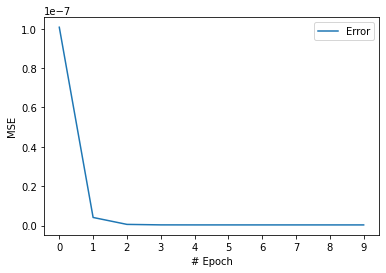

In [ ]:
import matplotlib.pyplot as plt
for key in loss.history.keys():
    plt.plot(loss.history[key],label="Error")
ax=plt.gca()
ax.locator_params('y', nbins=10)
plt.locator_params('x', nbins=10)
plt.xlabel("# Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
x